Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

Step 4: Fit a wavelength solution to the lamp composite. 

Step 5: Extract the 1-D spectrum and its wavelength solution.

**Step 6: Apply a relative flux calibration.**

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from matplotlib import pyplot as plt 

from astropy import units as u
from astropy import constants
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.polynomial import Polynomial1D
from astropy.io import ascii
from astropy.table import Table


Flux calibration is performed using a star of known flux. By comparing its brightness as a function of wavelength, we can derive a function that reflects the system response and allows us to calibrate the flux of our other observations. For the lab, our flux standard is Regulus. 

# (0) read in the data 

In [2]:
# reduced, wavelength calibrated 1D spectrum 
spec = np.load('regulus_spec.npy')
wave = np.load('regulus_wave.npy')

regulus_hdr = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/regulus.fits')[0].header

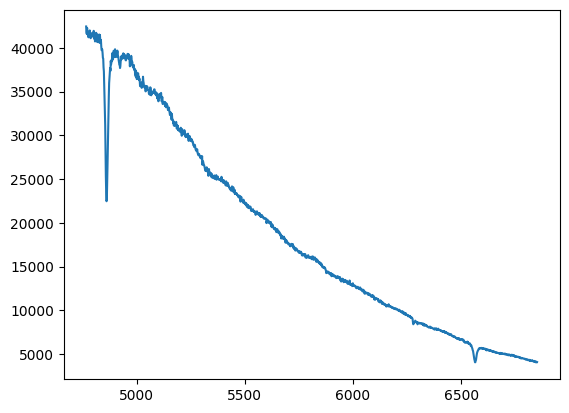

In [3]:
plt.plot(wave, spec)

We'll compare our observations with a table of observed fluxes. These data are available within some software packages (like IRAF) and as standalone tables. We want the file 'hr3982' (another name for Regulus - you can check this by looking the object up on Simbad). 

In [4]:
# the 3 columns in the file are: wavelength (Angstrom), magnitude, bandpass
std_dat = Table.read('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/hr3982.dat', format='ascii', 
                    names=['wave','mag','bp'])

In [5]:
std_dat.pprint()

 wave   mag   bp 
------ ----- ----
3200.0 1.856 49.0
3250.0 1.856 49.0
3300.0 1.856 49.0
3350.0 1.856 49.0
3400.0 1.855 49.0
3450.0 1.859 49.0
3500.0 1.854 49.0
   ...   ...  ...
6436.0  1.56 98.0
6790.0  1.62 98.0
7100.0 1.679 98.0
7550.0  1.78 98.0
7780.0 1.816 98.0
8090.0 1.861 98.0
8370.0 1.902 98.0
Length = 29 rows


First, we need to select the points that correspond to the spectral range we observed. 

In [6]:
#in_spec = np.where((std_dat['wave'] > wave.min()) & (std_dat['wave'] < wave.max()))
in_spec = np.where(((std_dat['wave']-std_dat['bp']) > wave.min()) & ((std_dat['wave']+std_dat['bp']) < wave.max()))

Text(0, 0.5, 'magnitude')

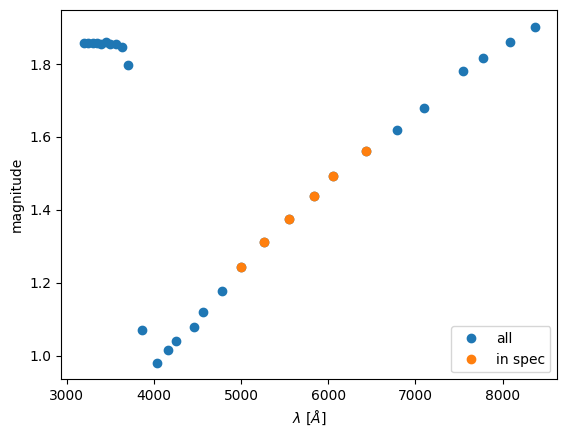

In [7]:
plt.plot(std_dat['wave'], std_dat['mag'], 'o')
plt.plot(std_dat['wave'][in_spec], std_dat['mag'][in_spec], 'o')
plt.legend(['all', 'in spec'])
plt.xlabel('$\\lambda$ [$\\AA$]')
plt.ylabel('magnitude')

Now, we add up the counts in our spectrum in each of those bandpasses. Our goal is to derive the multiplicative factor required for our spectrum to match the correct relative values. 

In [8]:
sum_counts = []

for cntr, wid in zip(std_dat['wave'][in_spec], std_dat['bp'][in_spec]):
    in_bp = np.where((wave > (cntr-wid)) & (wave < (cntr+wid)))
    #in_bp = np.where((wave > (cntr-wid/2.)) & (wave < (cntr+wid/2.)))
    sum_counts.append(np.nansum(spec[in_bp]))

In [9]:
std_dat['wave'][in_spec]

5000.0
5263.0
5556.0
5840.0
6056.0
6436.0


In [10]:
sum_counts

[2414160.630563792,
 1845631.5637492728,
 2726801.2967394153,
 1974705.0302370125,
 1568244.4169157164,
 943691.0134707168]

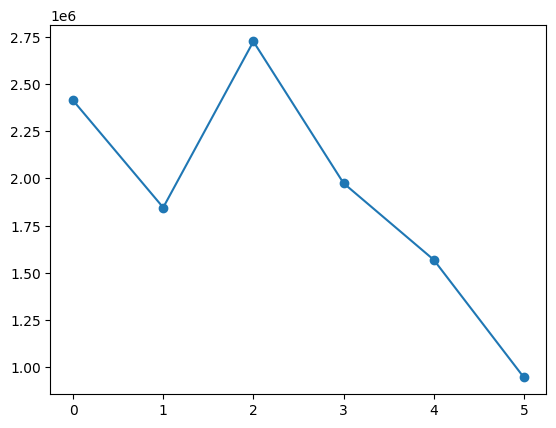

In [11]:
plt.plot(sum_counts, 'o-')

The magnitudes given for the standard star are AB magnitudes (see, e.g., https://lweb.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html for more information on magnitude systems). AB mags are defined as 

m_AB = -2.5 log(f_nu) - 48.60

where the fluxes are in units erg/s/cm^2/Hz. For monochromatic flux, m_AB = V. 

We can use this to convert the standard mags to flux. 

In [12]:
# use astropy units to keep track of our units 
fnd_flx = 10.**((std_dat['mag'][in_spec] + 48.60) / (-2.5)) * u.erg * u.cm**-2 * u.s**-1 * u.Hz**-1

As in IRAF, https://iraf.readthedocs.io/en/latest/tasks/noao/imred/irs/sensfunc.html, we will compute the calibration factor at each point as

C = 2.5 log (O / (T B F))

where O is the observed counts in the bandpass, T is the exposure time, B is the bandpass width, F is the flux **per Angstrom** at the bandpass for the standard star. The ratio C is the observed count rate per Angstrom over the expected flux expressed in magnitudes. 



First, we computed the fluxes of the standard star in erg/s/cm^2/**Hz** but we want to measured fluxes in erg/s/cm^2/**Angstrom**. So we need to do a little unit conversion. 

In [13]:
# freq = c / lambda 
freq = (constants.c / (std_dat['wave'][in_spec] * u.Angstrom)).to(u.Hz)

In [14]:
std_flx = fnd_flx * freq / (std_dat['wave'][in_spec] * u.Angstrom)

In [15]:
std_flx

<Quantity [1.38701352e-09, 1.17369151e-09, 9.94709415e-10, 8.47998353e-10,
           7.51015620e-10, 6.24580804e-10] erg / (Angstrom s cm2)>

In [16]:
1.4058e-9 / std_flx[0].value

1.0135445546966275

In [17]:
1.1896E-9 / std_flx[1].value

1.0135542349883746

We can find the exposure time of the observations in the header. 

In [18]:
regulus_hdr

SIMPLE  =                    T                                                  
BITPIX  =                   16 / bits per data value                            
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 1374 / Length of data axis 1                          
NAXIS2  =                 1099 / Length of data axis 2                          
SWCREATE= 'Demetra v4.2.0.0' / Software used to generate this file              
BIN1    =                    2 / Binning on axis 1                              
BIN2    =                    2 / Binning on axis 2                              
DATAMAX =                65535 / [adu] maximum value for all pixels             
DATAMIN =                    0 / [adu] minimum value for all pixels             
BSCALE  =                    1 / linear factor in scaling equation              
BZERO   =                22527 / zero point in scaling equation                 
DATE-OBS= '2023-02-04T01:49:

In [19]:
texp = regulus_hdr['EXPTIME']

Now we compute the function C. 

In [20]:
cfac = 2.5 * np.log10(np.array(sum_counts) / (texp * std_dat['bp'][in_spec]  * std_flx.value))

In [21]:
cfac

31.37622347252681
31.265987414755024
31.11682796841847
30.93970287017333
30.821346761125564
30.470037779065002


The goal is to fit the observations to the relation

C = S(W)

where W is the wavelength and S(W) is the sensitivity function. 

Let's start with a simply (linear) polynomial fit.

In [22]:
# We fit a 2nd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, std_dat['wave'][in_spec], cfac)

fitted_polymodel

<Polynomial1D(2, c0=27.96992147, c1=0.00169113, c2=-0.0000002)>

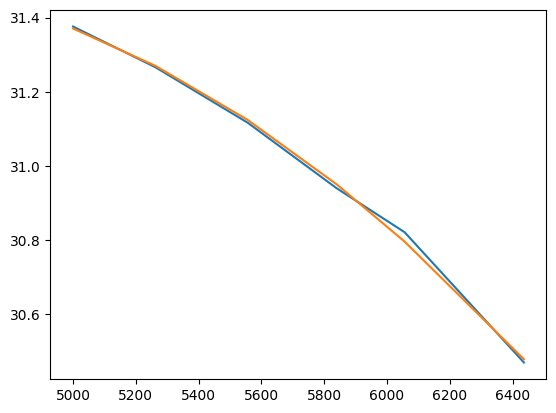

In [23]:
plt.plot(std_dat['wave'][in_spec], cfac)
plt.plot(std_dat['wave'][in_spec], fitted_polymodel(std_dat['wave'][in_spec]))

Apply the calibration to the spectrum.

In [24]:
mod_flx = 10**(fitted_polymodel(wave)/2.5)

In [25]:
flux_cal = spec/mod_flx

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\A'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_19784/2278717015.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$ [$\AA$]')
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_19784/2278717015.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Flux [erg/s/cm$^2$/$\AA$]')


Text(0, 0.5, 'Flux [erg/s/cm$^2$/$\\AA$]')

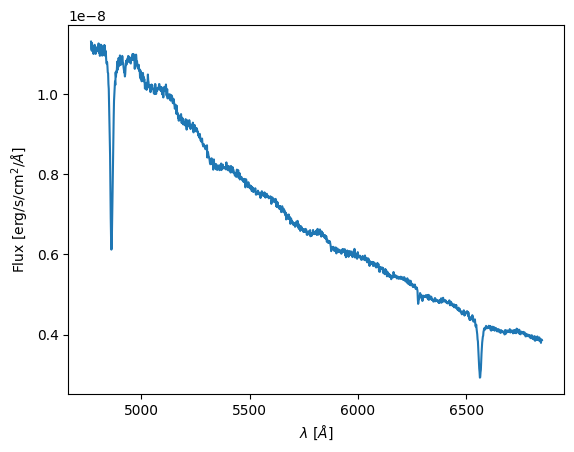

In [26]:
plt.plot(wave, flux_cal)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('Flux [erg/s/cm$^2$/$\AA$]')

If you are satisfied with the flux calibration (how can you check that everything went well??), then apply the correction to the target spectra. Be sure to save the flux-calibrated result. 